# Eigenvalue distribution of Gaussian orthogonal random matrices

modified ipynb example from https://github.com/ipython/ipyparallel  
The eigenvalues of random matrices obey certain statistical laws. Here we construct random matrices 
from the Gaussian Orthogonal Ensemble (GOE), find their eigenvalues and then investigate the nearest
neighbor eigenvalue distribution $\rho(s)$.

In [1]:
from rmtkernel import ensemble_diffs, normalize_diffs, GOE
import numpy as np
import ipyparallel as ipp
from matplotlib import pyplot as plt

## Wigner's nearest neighbor eigenvalue distribution

The Wigner distribution gives the theoretical result for the nearest neighbor eigenvalue distribution
for the GOE:

$$\rho(s) = \frac{\pi s}{2} \exp(-\pi s^2/4)$$

In [2]:
def wigner_dist(s):
    """Returns (s, rho(s)) for the Wigner GOE distribution."""
    return (np.pi*s/2.0) * np.exp(-np.pi*s**2/4.)

In [3]:
def generate_wigner_data():
    s = np.linspace(0.0,4.0,400)
    rhos = wigner_dist(s)
    return s, rhos

In [4]:
s, rhos = generate_wigner_data()

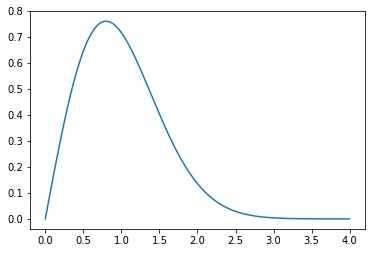

In [5]:
fig,ax=plt.subplots()
plt.plot(s, rhos)
#plt.xlabel('Normalized level spacing s')
#plt.ylabel('Probability $\rho(s)$')

## Serial calculation of nearest neighbor eigenvalue distribution

In this section we numerically construct and diagonalize a large number of GOE random matrices
and compute the nerest neighbor eigenvalue distribution. This comptation is done on a single core.

In [6]:
def serial_diffs(num, N):
    """Compute the nearest neighbor distribution for num NxX matrices."""
    diffs = ensemble_diffs(num, N)
    normalized_diffs = normalize_diffs(diffs)
    return normalized_diffs

In [7]:
serial_nmats = 5000
serial_matsize = 50

In [8]:
%timeit -n5 sdiffs=serial_diffs(serial_nmats, serial_matsize)

5 loops, best of 3: 6.43 s per loop


The numerical computation agrees with the predictions of Wigner, but it would be nice to get more
statistics. For that we will do a parallel computation.

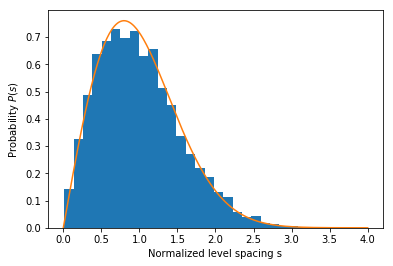

In [9]:
sdiffs=serial_diffs(serial_nmats, serial_matsize)
hist_data = plt.hist(sdiffs, bins=30, normed=True)
plt.plot(s, rhos)
plt.xlabel('Normalized level spacing s')
plt.ylabel('Probability $P(s)$')

## Parallel calculation of nearest neighbor eigenvalue distribution

Here we perform a parallel computation, where each process constructs and diagonalizes a subset of
the overall set of random matrices.

In [10]:
### profile para1 will start 15 engines and controller on the server
#ipcluster start --profile=para1
### use the engine json file to start remote engines
### see notebook-win.yml for the environment 
### and json file is under security folder in the profile para1
### activate the environment and start the engine(each engine is 1 execution)
#activate notebook-win
#ipengine --file=ipcontroller-notebook-win-engine.json
client = ipp.Client('ipcontroller-notebook-win-client.json')
view = client[:]
#view = client.load_balanced_view()
view.run('rmtkernel.py')
view.block = False

In [11]:
client.ids[:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [12]:
parallel_nmats =serial_nmats
parallel_matsize = serial_matsize

In [13]:
#diffs=view.map(lambda x:center_eigenvalue_diff(x),GOE(parallel_matsize))
def parallel_diffs(rc, num, N):
    diffs=np.empty(num)
    results=rc.map(lambda x:center_eigenvalue_diff(GOE(N)),diffs)
    diffs = np.array(results.get()).flatten()
    normalized_diffs = normalize_diffs(diffs)
    return normalized_diffs
%timeit -n5 hdiffs=parallel_diffs(view, parallel_nmats, parallel_matsize)

5 loops, best of 3: 684 ms per loop


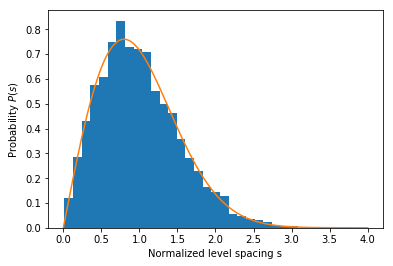

In [14]:
hdiffs=parallel_diffs(view, parallel_nmats, parallel_matsize)
hist_data = plt.hist(hdiffs, bins=30, normed=True)
plt.plot(s, rhos)
plt.xlabel('Normalized level spacing s')
plt.ylabel('Probability $P(s)$')

In [15]:
"""
original example is a bad method
def parallel_diffs(rc, num, N):
    nengines = len(rc.targets)
    num_per_engine = num/nengines
    print "Running with", num_per_engine, "per engine."
    ar = rc.apply_async(ensemble_diffs, num_per_engine, N)
    diffs = np.array(ar.get()).flatten()
    normalized_diffs = normalize_diffs(diffs)
    return normalized_diffs
%timeit -r1 -n1 parallel_diffs(view, parallel_nmats, parallel_matsize)
"""

'\noriginal example is a bad method\ndef parallel_diffs(rc, num, N):\n    nengines = len(rc.targets)\n    num_per_engine = num/nengines\n    print "Running with", num_per_engine, "per engine."\n    ar = rc.apply_async(ensemble_diffs, num_per_engine, N)\n    diffs = np.array(ar.get()).flatten()\n    normalized_diffs = normalize_diffs(diffs)\n    return normalized_diffs\n%timeit -r1 -n1 parallel_diffs(view, parallel_nmats, parallel_matsize)\n'